# FER13 basic model with data Imbalance handled

Label distribution:
angry: 4953 images
disgust: 547 images
fear: 5121 images
happy: 8989 images
neutral: 6198 images
sad: 6077 images
surprise: 4002 images
Running configuration: No Data Augmentation
Test Accuracy: 49.50%
Precision: 0.90
Recall: 0.91
F1 Score: 0.90

Summary of Results:
Configuration 1: No Data Augmentation
Test Accuracy: 49.50%
Precision: 0.90
Recall: 0.91
F1 Score: 0.90


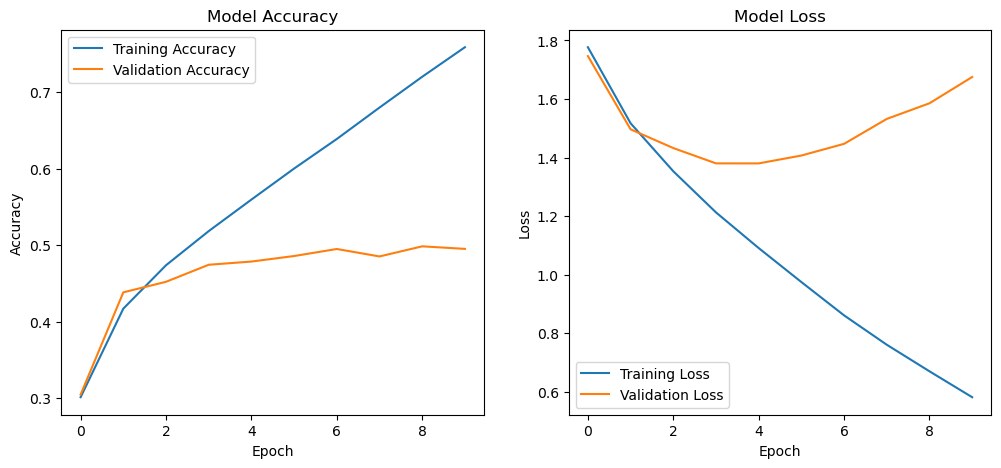

In [1]:
import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from collections import Counter

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the FER2013 dataset folder
dataset_folder = r""
# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.jpg'):  # Check for .jpg files
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the CNN architecture function
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# No data augmentation configuration
config = {
    "shear_range": 0.0,
    "zoom_range": 0.0,
    "rotation_range": 0,
    "width_shift_range": 0.0,
    "height_shift_range": 0.0,
    "horizontal_flip": False
}

print(f"Running configuration: No Data Augmentation")

# Create the model
model = create_model()

# Define data augmentation configuration (with no augmentation)
datagen = ImageDataGenerator(
    shear_range=config["shear_range"],
    zoom_range=config["zoom_range"],
    rotation_range=config["rotation_range"],
    width_shift_range=config["width_shift_range"],
    height_shift_range=config["height_shift_range"],
    horizontal_flip=config["horizontal_flip"]
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Train the model using class weights and the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    validation_data=(X_test, y_test),
    epochs=10,
    class_weight=class_weights_dict,
    verbose=0  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Store the configuration and results
config_results = {
    'config': 'No Data Augmentation',
    'test_accuracy': test_acc,
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1_score
}

# Print the results for this configuration
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

results.append(config_results)

print("\nSummary of Results:")
for idx, result in enumerate(results):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# data augmentation with the balanced dataset

Label distribution:
angry: 4953 images
disgust: 547 images
fear: 5121 images
happy: 8989 images
neutral: 6198 images
sad: 6077 images
surprise: 4002 images
Running configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Running configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': True}
Running configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.1, 'horizontal_flip': False}
Running configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.1, 'horizontal_flip': True}
Running configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.1, 'height_shift_range': 0.0, 'horizontal_flip': False}
Running configuration: {'shear_

Running configuration: {'shear_range': 0.15, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.1, 'horizontal_flip': False}
Running configuration: {'shear_range': 0.15, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.1, 'horizontal_flip': True}
Running configuration: {'shear_range': 0.15, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.1, 'height_shift_range': 0.0, 'horizontal_flip': False}
Running configuration: {'shear_range': 0.15, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.1, 'height_shift_range': 0.0, 'horizontal_flip': True}
Running configuration: {'shear_range': 0.15, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.1, 'height_shift_range': 0.1, 'horizontal_flip': False}
Running configuration: {'shear_range': 0.15, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.1, 'height_shift_range': 0.1, 'horizontal_flip': True}
Running configurati

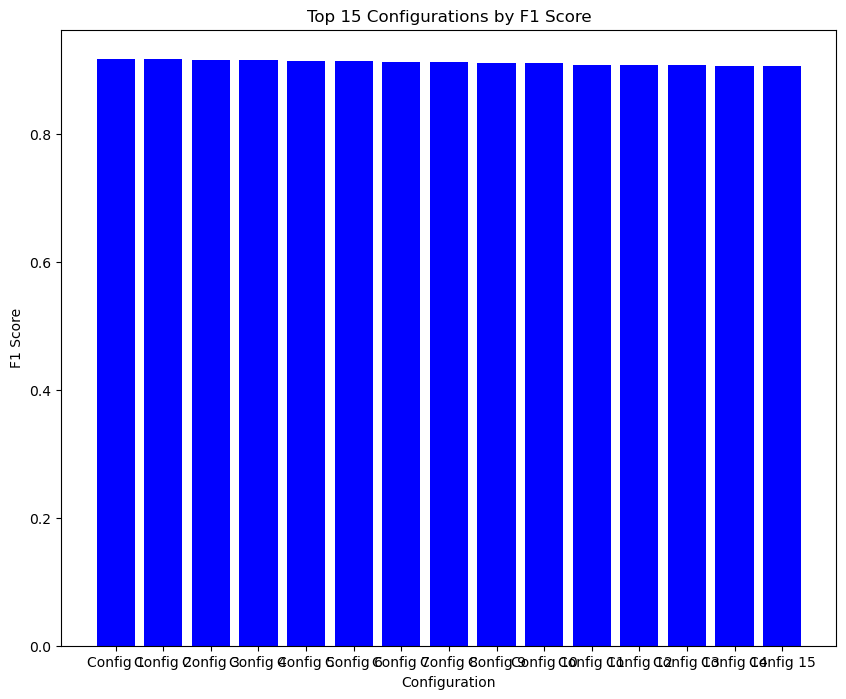

In [1]:
import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from collections import Counter
from itertools import product

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
<Figure size 1000x500 with 10 Axes>
Label distribution:
anger: 30 images
neutral: 30 images
sadness: 31 images
surprise: 30 images
happiness: 31 images
fear: 32 images
disgust: 29 images
Running configuration 1/12: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 1: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 76.74%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99
==================================================
Running configuration 2/12: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 2: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 81.40%
Precision: 1.00
Recall: 0.97
F1 Score: 0.99
==================================================
Running configuration 3/12: {'shear_range': 0.0, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 3: {'shear_range': 0.0, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 95.35%
Precision: 1.00
Recall: 0.97
F1 Score: 0.99
==================================================
Running configuration 4/12: {'shear_range': 0.0, 'zoom_range': 0.1, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 4: {'shear_range': 0.0, 'zoom_range': 0.1, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 20.93%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94
==================================================
Running configuration 5/12: {'shear_range': 0.0, 'zoom_range': 0.2, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 5: {'shear_range': 0.0, 'zoom_range': 0.2, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 81.40%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97
==================================================
Running configuration 6/12: {'shear_range': 0.0, 'zoom_range': 0.2, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 6: {'shear_range': 0.0, 'zoom_range': 0.2, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 16.28%
Precision: 0.92
Recall: 0.63
F1 Score: 0.75
==================================================
Running configuration 7/12: {'shear_range': 0.2, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 7: {'shear_range': 0.2, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 83.72%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
==================================================
Running configuration 8/12: {'shear_range': 0.2, 'zoom_range': 0.0, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 8: {'shear_range': 0.2, 'zoom_range': 0.0, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 9.30%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94
==================================================
Running configuration 9/12: {'shear_range': 0.2, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 9: {'shear_range': 0.2, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 93.02%
Precision: 0.95
Recall: 0.97
F1 Score: 0.96
==================================================
Running configuration 10/12: {'shear_range': 0.2, 'zoom_range': 0.1, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 10: {'shear_range': 0.2, 'zoom_range': 0.1, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 16.28%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94
==================================================
Running configuration 11/12: {'shear_range': 0.2, 'zoom_range': 0.2, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 11: {'shear_range': 0.2, 'zoom_range': 0.2, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 9.30%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94
==================================================
Running configuration 12/12: {'shear_range': 0.2, 'zoom_range': 0.2, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Configuration 12: {'shear_range': 0.2, 'zoom_range': 0.2, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 20.93%
Precision: 0.94
Recall: 0.76
F1 Score: 0.84
==================================================

Top 1 Configuration: {'shear_range': 0.0, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 95.35%
Precision: 1.00
Recall: 0.97
F1 Score: 0.99

<Figure size 640x480 with 2 Axes>
<Figure size 1200x500 with 2 Axes>

Top 2 Configuration: {'shear_range': 0.2, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 93.02%
Precision: 0.95
Recall: 0.97
F1 Score: 0.96

<Figure size 640x480 with 2 Axes>
<Figure size 1200x500 with 2 Axes>

Top 3 Configuration: {'shear_range': 0.2, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 83.72%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

<Figure size 640x480 with 2 Axes>
<Figure size 1200x500 with 2 Axes>

Top 4 Configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 81.40%
Precision: 1.00
Recall: 0.97
F1 Score: 0.99

<Figure size 640x480 with 2 Axes>
<Figure size 1200x500 with 2 Axes>

Top 5 Configuration: {'shear_range': 0.0, 'zoom_range': 0.2, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 81.40%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97

<Figure size 640x480 with 2 Axes>
<Figure size 1200x500 with 2 Axes>

Top 6 Configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 76.74%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99

<Figure size 640x480 with 2 Axes>
<Figure size 1200x500 with 2 Axes>

Top 7 Configuration: {'shear_range': 0.0, 'zoom_range': 0.1, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 20.93%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94

<Figure size 640x480 with 2 Axes>
<Figure size 1200x500 with 2 Axes>

Top 8 Configuration: {'shear_range': 0.2, 'zoom_range': 0.2, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 20.93%
Precision: 0.94
Recall: 0.76
F1 Score: 0.84

<Figure size 640x480 with 2 Axes>
<Figure size 1200x500 with 2 Axes>

Top 9 Configuration: {'shear_range': 0.0, 'zoom_range': 0.2, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 16.28%
Precision: 0.92
Recall: 0.63
F1 Score: 0.75

<Figure size 640x480 with 2 Axes>
<Figure size 1200x500 with 2 Axes>

Top 10 Configuration: {'shear_range': 0.2, 'zoom_range': 0.1, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 16.28%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94

<Figure size 640x480 with 2 Axes>
<Figure size 1200x500 with 2 Axes>

Top 11 Configuration: {'shear_range': 0.2, 'zoom_range': 0.0, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 9.30%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94

<Figure size 640x480 with 2 Axes>
<Figure size 1200x500 with 2 Axes>

Top 12 Configuration: {'shear_range': 0.2, 'zoom_range': 0.2, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 9.30%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94

<Figure size 640x480 with 2 Axes>
<Figure size 1200x500 with 2 Axes>

Summary of Top 15 Configurations:
Configuration 1: {'shear_range': 0.0, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 95.35%
Precision: 1.00
Recall: 0.97
F1 Score: 0.99
==================================================
Configuration 2: {'shear_range': 0.2, 'zoom_range': 0.1, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 93.02%
Precision: 0.95
Recall: 0.97
F1 Score: 0.96
==================================================
Configuration 3: {'shear_range': 0.2, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 83.72%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
==================================================
Configuration 4: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 81.40%
Precision: 1.00
Recall: 0.97
F1 Score: 0.99
==================================================
Configuration 5: {'shear_range': 0.0, 'zoom_range': 0.2, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 81.40%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97
==================================================
Configuration 6: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 76.74%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99
==================================================
Configuration 7: {'shear_range': 0.0, 'zoom_range': 0.1, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 20.93%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94
==================================================
Configuration 8: {'shear_range': 0.2, 'zoom_range': 0.2, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 20.93%
Precision: 0.94
Recall: 0.76
F1 Score: 0.84
==================================================
Configuration 9: {'shear_range': 0.0, 'zoom_range': 0.2, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 16.28%
Precision: 0.92
Recall: 0.63
F1 Score: 0.75
==================================================
Configuration 10: {'shear_range': 0.2, 'zoom_range': 0.1, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 16.28%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94
==================================================
Configuration 11: {'shear_range': 0.2, 'zoom_range': 0.0, 'rotation_range': 10, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 9.30%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94
==================================================
Configuration 12: {'shear_range': 0.2, 'zoom_range': 0.2, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 9.30%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94
==================================================

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.jpg'):  # Check for .jpg files
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the CNN architecture function
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(len(np.unique(labels_encoded)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to generate augmentation combinations
def get_augmentation_combinations():
    shear_ranges = [0.0, 0.15]
    zoom_ranges = [0.0, 0.1]
    rotation_ranges = [0, 15]
    width_shift_ranges = [0.0, 0.1]
    height_shift_ranges = [0.0, 0.1]
    horizontal_flip_options = [False, True]

    combinations = list(product(shear_ranges, zoom_ranges, rotation_ranges,
                                width_shift_ranges, height_shift_ranges, horizontal_flip_options))
    return combinations

# Initialize list to store results
results = []

# Iterate over each augmentation combination
for combination in get_augmentation_combinations():
    shear_range, zoom_range, rotation_range, width_shift_range, height_shift_range, horizontal_flip = combination

    config = {
        "shear_range": shear_range,
        "zoom_range": zoom_range,
        "rotation_range": rotation_range,
        "width_shift_range": width_shift_range,
        "height_shift_range": height_shift_range,
        "horizontal_flip": horizontal_flip
    }

    print(f"Running configuration: {config}")

    # Create the model
    model = create_model()

    # Define data augmentation configuration
    datagen = ImageDataGenerator(
        shear_range=config["shear_range"],
        zoom_range=config["zoom_range"],
        rotation_range=config["rotation_range"],
        width_shift_range=config["width_shift_range"],
        height_shift_range=config["height_shift_range"],
        horizontal_flip=config["horizontal_flip"]
    )

    # Fit the data generator to the training data
    datagen.fit(X_train)

    # Train the model using class weights and the data generator
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32, seed=42),
        validation_data=(X_test, y_test),
        epochs=10,
        class_weight=class_weights_dict,
        verbose=0
    )

    # Evaluate the model and store the results
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    precision = tf.keras.metrics.Precision()
    precision.update_state(true_classes, predicted_classes)
    recall = tf.keras.metrics.Recall()
    recall.update_state(true_classes, predicted_classes)
    f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

    # Store the configuration and results
    config_results = {
        'config': config,
        'test_accuracy': test_acc,
        'precision': precision.result().numpy(),
        'recall': recall.result().numpy(),
        'f1_score': f1_score
    }

    results.append(config_results)

# Sort results by F1 score and display the top 15
results_sorted = sorted(results, key=lambda x: x['f1_score'], reverse=True)[:15]
print("\nTop 15 Performing Configurations:")
for idx, result in enumerate(results_sorted):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")

# Plotting the top configurations
plt.figure(figsize=(10, 8))
x = range(1, 16)
y = [result['f1_score'] for result in results_sorted]
plt.bar(x, y, color='blue')
plt.xlabel('Configuration')
plt.ylabel('F1 Score')
plt.title('Top 15 Configurations by F1 Score')
plt.xticks(x, [f"Config {i}" for i in x])
plt.show()


In [ ]:
# for tunning model

In [1]:
import os
import random
import numpy as np
from PIL import Image
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import product
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the FER2013 dataset folder
dataset_folder = r'/Users/arkamandol/Downloads/linda_trials/FER2013'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.jpg'):  # Load .jpg files
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define data augmentation configuration
datagen = ImageDataGenerator(
    shear_range=0.15,
    zoom_range=0.1,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=False
)

# Fit the generator to the training data
datagen.fit(X_train)

# Define parameter combinations
parameter_combinations = list(product(
    [1, 2],  # conv_layers_options
    [32, 64],  # filters_options
    [1, 2],  # dense_layers_options
    [64, 128],  # dense_units_options
    [0.1, 0.2, 0.3],  # dropout_options
    [50],  # epochs_options
    [32, 64],  # batch_size_options
    [0.001, 0.002],  # learning_rate_options
    ['relu'],  # activation_options
    ['adam']  # optimizer_options
))

# Initialize variables to store configurations and their results
all_results = []
config_results = defaultdict(list)

# Loop over all parameter combinations
for idx, (conv_layers, filters, dense_layers, dense_units, dropout, epochs, batch_size, learning_rate, activation, optimizer) in enumerate(parameter_combinations):
    # Initialize and compile the model based on current configuration
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),
        *[layer for i in range(conv_layers) for layer in (Conv2D(filters, (3, 3), activation=activation), MaxPooling2D((2, 2)))],
        Flatten(),
        *[layer for i in range(dense_layers) for layer in (Dense(dense_units, activation=activation), Dropout(dropout))],
        Dense(len(np.unique(labels_encoded)), activation='softmax')
    ])
    optimizer_instance = Adam(learning_rate=learning_rate) if optimizer == 'adam' else SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with data augmentation
    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights_dict, verbose=0)

    # Evaluate model performance
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    precision = tf.keras.metrics.Precision()(true_classes, predicted_classes).numpy()
    recall = tf.keras.metrics.Recall()(true_classes, predicted_classes).numpy()
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Store configuration and results
    current_config = {
        'conv_layers': conv_layers,
        'filters': filters,
        'dense_layers': dense_layers,
        'dense_units': dense_units,
        'dropout': dropout,
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'activation': activation,
        'optimizer': optimizer
    }
    print(f"Configuration {idx + 1}: {current_config} - F1 Score: {f1_score:.4f}")
    all_results.append((f1_score, current_config, history))

# Sort configurations by best F1 score
all_results.sort(reverse=True, key=lambda x: x[0])

# Display top 15 configurations
top_15 = all_results[:15]
for i, (f1_score, config, history) in enumerate(top_15, start=1):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Config {i} Accuracy (F1 Score: {f1_score:.4f})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Config {i} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


Configuration 1: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'} - F1 Score: 0.8902
Configuration 2: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'} - F1 Score: 0.8817



KeyboardInterrupt



Running configuration 1/192


NameError: name 'config' is not defined

In [ ]:
import os
import random
import numpy as np
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import product
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'/Users/arkamandol/Downloads/linda_trials/FER2013'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.jpg'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')
                    img = img.resize((64, 64))
                    img_array = np.array(img) / 255.0
                    images.append(img_array)
                    labels.append(label_folder)
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dict = dict(enumerate(class_weights))

# Define data augmentation configuration
datagen = ImageDataGenerator(
    shear_range=0.15,
    zoom_range=0.1,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=False
)
datagen.fit(X_train)

# Parameter combinations using itertools.product
parameter_combinations = list(product(
    [1, 2], 
    [32, 64], 
    [1, 2], 
    [64, 128], 
    [ 0.2, 0.3], 
    [10,20], 
    [32, 64], 
    [0.001, 0.002], 
    ['relu'], 
    ['adam']))

# Initialize results list
results = []

# Loop over all parameter combinations
for idx, (conv_layers, filters, dense_layers, dense_units, dropout, epochs, batch_size, learning_rate, activation, optimizer) in enumerate(parameter_combinations):
    current_config = {
        'conv_layers': conv_layers,
        'filters': filters,
        'dense_layers': dense_layers,
        'dense_units': dense_units,
        'dropout': dropout,
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'activation': activation,
        'optimizer': optimizer
    }
    print(f"Running configuration {idx+1}/{len(parameter_combinations)}")

    # Define and compile the CNN model
    model = Sequential()
    model.add(InputLayer(input_shape=(64, 64, 1)))
    for _ in range(conv_layers):
        model.add(Conv2D(filters, (3, 3), activation=activation))
        model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    for _ in range(dense_layers):
        model.add(Dense(dense_units, activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

    # Select optimizer
    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    else:
        optimizer_instance = SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with data augmentation
    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), validation_data=(X_test, y_test), epochs=epochs, class_weight=class_weights_dict, verbose=0)

    # Evaluate the model and store the results
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    precision.update_state(true_classes, predicted_classes)
    recall.update_state(true_classes, predicted_classes)
    f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

    # Store results
    results.append({
        'config': current_config,
        'test_accuracy': test_acc,
        'precision': precision.result().numpy(),
        'recall': recall.result().numpy(),
        'f1_score': f1_score,
        'history': history  # Save history for later plotting
    })
    print({
        'config': current_config,
        'test_accuracy': test_acc,
        'precision': precision.result().numpy(),
        'recall': recall.result().numpy(),
        'f1_score': f1_score,
        'history': history  # Save history for later plotting
    })

# Sort results by F1 score in descending order and select the top 15
top_results = sorted(results, key=lambda x: x['f1_score'], reverse=True)[:15]

# Print and plot the top 15 results
for idx, result in enumerate(top_results):
    config = result['config']
    history = result['history']
    print(f"Top {idx+1} Configuration: {config}")
    print(f"Metrics - Accuracy: {result['test_accuracy']*100:.2f}%, Precision: {result['precision']:.4f}, Recall: {result['recall']:.4f}, F1 Score: {result['f1_score']:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Config {idx+1} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Config {idx+1} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


Running configuration 1/256
{'config': {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 10, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}, 'test_accuracy': 0.014210086315870285, 'precision': 0.86003065, 'recall': 0.9995139, 'f1_score': 0.9245410119501327, 'history': <keras.src.callbacks.history.History object at 0x1091414b0>}
Running configuration 2/256
{'config': {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 10, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}, 'test_accuracy': 0.43967679142951965, 'precision': 0.8885848, 'recall': 0.8941996, 'f1_score': 0.8913833292767408, 'history': <keras.src.callbacks.history.History object at 0x2854d3a60>}
Running configuration 3/256
{'config': {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 10, 'batch_size': 64, 'learning_r